# Causal reasoning in dynamical systems

In [1]:
# %reload_ext autoreload
# %autoreload 2

import warnings

warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = ('CI' in os.environ)
num_steps = 10 if smoke_test else 500
num_samples = 10 if smoke_test else 100

## Overview: Causal Inference in Continuous Time Dynamical Systems

### **Task:** Modeling Causal Interventions in Continuous Time Systems
This tutorial focuses on understanding and estimating the causal effects of interventions in systems described by continuous time dynamics. We use ChiRho to model scenarios where interventions occur at specific moments in time, impacting the trajectory of a system governed by ordinary differential equations (ODEs). This approach is particularly relevant for complex systems in physics, biology, and engineering where time-continuous processes are fundamental representations of cause-effect mechanistic knowledge.

### **Challenge:** Representational Complexities of ODEs in Causal Inference
One of the primary challenges in using ordinary differential equations (ODEs) for causal inference lies in their representational nature. ODEs inherently contain causal semantics, as they describe how changes in one variable lead to changes in others over continuous time. However, they do not map directly onto causal graphical models, primarily due to their cyclic dependencies. Unlike causal graphs, which are typically acyclic, ODEs often represent feedback loops and reciprocal relationships between variables. This cyclic nature complicates the task of inferring causal relationships, as it challenges the conventional assumptions and methods used in causal inference, which are primarily developed for acyclic structures.

### **Approach:** Leveraging ODEs for Causal Reasoning
ChiRho tackles these representational challenges by providing a generic semantics of interventions in continuous time dynamical systems by interrupting and modifying the behavior of simulation runs. This allows ChiRho to provide automated support for common interventional and counterfactual questions described throughout the causal inference literature to be used in continuous time dynamical systems models. As we'll see in subsequent tutorials, providing an intervention semantics for continuous time dynamical systems makes it almost trivial to define hybrid models that combine continuous time component (e.g. disease dynamics) with atemporal components (hierarchical regression). 

### **Assumptions:** Deterministic Dynamics and No Latent Confounders
In this tutorial, we make several key assumptions. First, we assume that all dynamics in the system are deterministic, meaning that the system's behavior can be precisely described by its current state and the governing equations without random variability. Secondly, we assume that the dynamical system model accurately captures the real-world processes it is intended to represent. This includes the correct formulation of the ODEs and a comprehensive representation of all relevant variables and their interactions. Lastly, we assume that there are no confounders between the model parameters. This means that the parameters are not influenced by unobserved variables that could bias our causal estimates. In subsequent tutorials we'll relax these assumptions.

### **Intuition:** Understanding Interventions in Dynamic Systems
The key intuition behind this approach is that interventions in continuous time systems can be represented as alterations to the parameters or state variables in the ODEs. By simulating how these changes propagate through the system over time, we can estimate the causal effect of interventions.

## Example: Assessing Intervention Strategies in an Epidemic Model

### Variables

In this example, we will explore the SIR (Susceptible, Infected, Recovered) compartmental model, a fundamental model in epidemiology. Here, the variables of interest are:
- $S(t)$: the number of susceptible individuals at time $t$,
- $I(t)$: the number of infected individuals at time $t$, and
- $R(t)$: the number of recovered individuals at time $t$.

These compartments interact through a set of ordinary differential equations that describe the rate at which individuals move from being susceptible to infected, and from infected to recovered.

### Motivation

Understanding the impact of different public health interventions on the spread of an infectious disease is crucial for policymakers and health officials. For example, policymakers may wish to predict the impacts of mask mandates, social distancing campaigns, or vaccination efforts. By simulating these interventions in the model, we can estimate their impact on the epidemic trajectory, such as changes in the peak infection rate or the total number of infections over time. In this example we'll see how to model such interventions using ChiRho.

### Source

The SIR model is a classical model in epidemiology, first proposed by Kermack and McKendrick in 1927. It has been widely used to understand and predict the spread of infectious diseases. For our tutorial, we will use simulated data that follows the dynamics of the SIR model. This data will allow us to demonstrate how ChiRho can be used to analyze the effects of interventions in a controlled setting, providing a clear illustration of the model's capabilities in causal inference with continuous time dynamical systems. In subsequent totorials we'll extend this simple SIR model using ChiRho's support for counterfactual and explanatory reasoning.

## Define our SIR model

In [67]:
class SimpleSIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    @pyro.nn.pyro_method
    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]) -> None:
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

    @pyro.nn.pyro_method
    def observation(self, X: State[torch.Tensor]) -> None:
        # We don't observe the number of susceptible individuals directly, and instead can only infer it from the
        #  number of test kits that are sold (which is a noisy function of the number of susceptible individuals).
        # Here we assume that the number of test kits sold is proportional to the number of susceptible individuals (S)
        #  and the number of infected individuals (I).
        event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0
        pyro.sample("test_kit_sales", dist.Normal(torch.log(torch.relu(X["S"] * X["I"]) + 1), 0.1).to_event(event_dim))
        pyro.sample("I_obs", dist.Poisson(X["I"]).to_event(event_dim))  # noisy number of infected actually observed
        pyro.sample("R_obs", dist.Poisson(X["R"]).to_event(event_dim))  # noisy number of recovered actually observed

    def forward(self, X: State[torch.Tensor]):
        dX = State()
        self.diff(dX, X)
        return dX

## Generate synthetic data from the SIR model

In [77]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = State(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(3.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)

# We now simulate from the SIR model
beta_true = torch.tensor(0.05)
gamma_true = torch.tensor(0.5)
sir_true = SimpleSIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory

In [78]:
sir_true_traj

{'S': tensor([99.0000, 98.3788, 97.4204, 95.9558, 93.7488, 90.4939, 85.8413, 79.4795,
         71.2871, 61.5094, 50.8364, 40.2483, 30.6751, 22.6955, 16.4604, 11.8108,
          8.4475,  6.0568,  4.3706,  3.1823,  2.3417,  1.7431,  1.3130,  1.0010,
          0.7724,  0.6029,  0.4760,  0.3800,  0.3066,  0.2498]),
 'I': tensor([ 1.0000,  1.5582,  2.4187,  3.7319,  5.7062,  8.6078, 12.7325, 18.3242,
         25.4289, 33.7313, 42.4985, 50.7511, 57.6083, 62.5752, 65.5980, 66.9282,
         66.9400, 66.0038, 64.4272, 62.4425, 60.2158, 57.8622, 55.4591, 53.0583,
         50.6934, 48.3861, 46.1499, 43.9927, 41.9187, 39.9295]),
 'R': tensor([ 0.0000,  0.0629,  0.1608,  0.3123,  0.5450,  0.8984,  1.4262,  2.1962,
          3.2840,  4.7593,  6.6651,  9.0005, 11.7167, 14.7296, 17.9416, 21.2611,
         24.6125, 27.9394, 31.2022, 34.3753, 37.4425, 40.3948, 43.2279, 45.9407,
         48.5343, 51.0110, 53.3741, 55.6273, 57.7748, 59.8206])}

### Simulate the latent trajectories of the ODE model

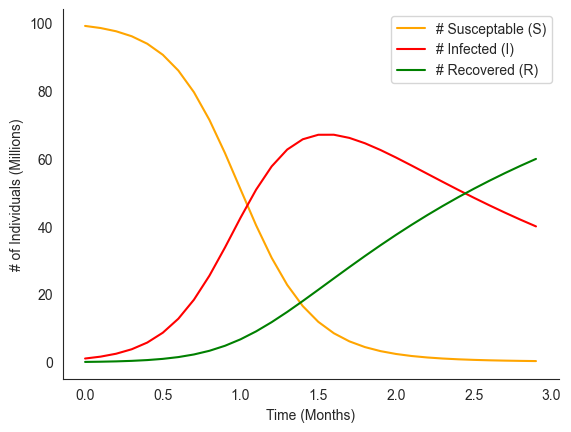

In [79]:
sns.lineplot(
    x=logging_times, y=sir_true_traj["S"], label="# Susceptable (S)", color="orange"
)
sns.lineplot(x=logging_times, y=sir_true_traj["I"], label="# Infected (I)", color="red")
sns.lineplot(x=logging_times, y=sir_true_traj["R"], label="# Recovered (R)", color="green")
sns.despine()
plt.xlabel("Time (Months)")
plt.ylabel("# of Individuals (Millions)")
plt.legend()

### Add noise to state trajectories to generate observations
 

In [80]:
obs_start_time = torch.tensor(0.5) # Measurements start 0.5 month into the pandemic
obs_end_time = torch.tensor(1.) # Measurements end 1 month into the pandemic
obs_sample_rate = torch.tensor(1/30) # Take measurements one per day
obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, obs_end_time)

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    sir_true.observation(sir_obs_traj)

sir_data = State(**{k:tr.trace.nodes[k]["value"] for k in ["test_kit_sales", "I_obs", "R_obs"]})

Text(0, 0.5, 'Observed # Recovered (Millions)')

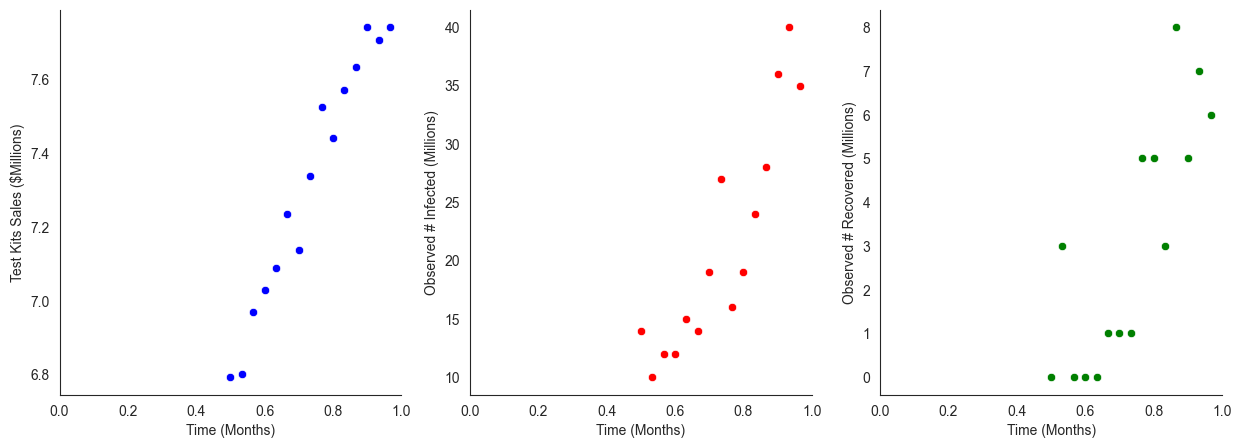

In [81]:
# Plot observed data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot test kit sales
sns.scatterplot(x=obs_logging_times, y=sir_data["test_kit_sales"], color="blue", ax=ax[0])
sns.despine()
ax[0].set_xlim(start_time, obs_end_time)
ax[0].set_xlabel("Time (Months)")
ax[0].set_ylabel("Test Kits Sales ($Millions)")

# Plot observed infected
sns.scatterplot(x=obs_logging_times, y=sir_data["I_obs"], color="red", ax=ax[1])
sns.despine()
ax[1].set_xlim(start_time, obs_end_time)
ax[1].set_xlabel("Time (Months)")
ax[1].set_ylabel("Observed # Infected (Millions)")

# Plot observed recovered
sns.scatterplot(x=obs_logging_times, y=sir_data["R_obs"], color="green", ax=ax[2])
sns.despine()
ax[2].set_xlim(start_time, obs_end_time)
ax[2].set_xlabel("Time (Months)")
ax[2].set_ylabel("Observed # Recovered (Millions)")

## Extend our model to include uncertainty over model parameters

In [82]:
# We place uniform priors on the beta and gamma parameters defining the SIR model
def bayesian_sir(base_model=SimpleSIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Uniform(0, 1))
    gamma = pyro.sample("gamma", dist.Uniform(0, 1))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(init_state, start_time, logging_times, base_model=SimpleSIRDynamics) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)
    with TorchDiffEq(), LogTrajectory(logging_times) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    trajectory = lt.trajectory
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, v) for k, v in trajectory.items()]
    return trajectory


def conditioned_sir(obs_times, data, init_state, start_time, base_model=SimpleSIRDynamics) -> None:
    sir = bayesian_sir(base_model)
    obs = condition(data=data)(sir.observation)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])

## Perform Inference!

In [83]:
# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, num_steps=num_steps, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [84]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
)

[iteration 0001] loss: 40941.7852
[iteration 0100] loss: 558.0534
[iteration 0200] loss: 69.2330
[iteration 0300] loss: 61.0472
[iteration 0400] loss: 73.3304
[iteration 0500] loss: 58.2393


## Evaluate the performance of our inference

In [85]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(simulated_bayesian_sir, guide=sir_guide, num_samples=num_samples)
sir_posterior_samples = sir_predictive(init_state, start_time, logging_times)

### First, we compare the approximate posterior distribution with the true beta and gamma parameters generating the data

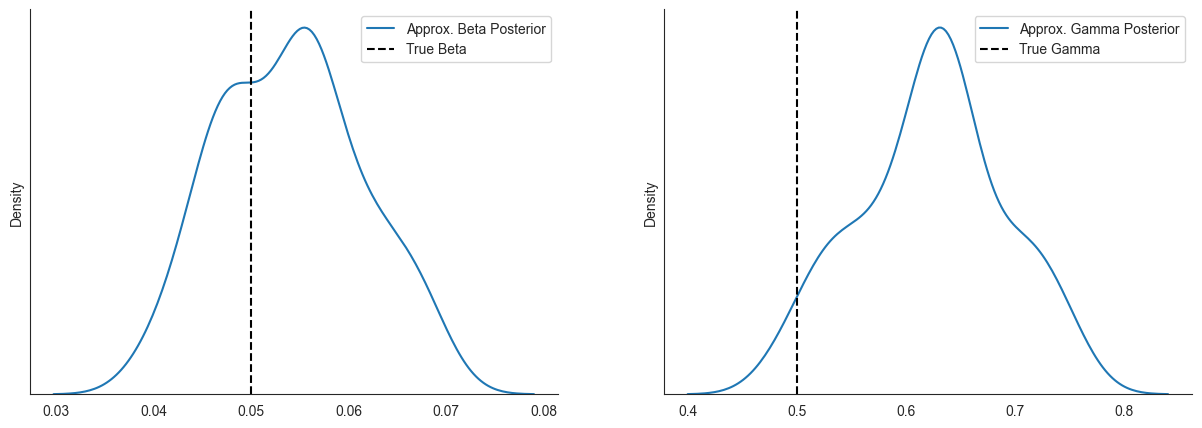

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(sir_posterior_samples["beta"], label="Approx. Beta Posterior", ax=ax[0])
ax[0].axvline(beta_true, color="black", label="True Beta", linestyle="--")
sns.despine()
ax[0].set_yticks([])
ax[0].legend(loc="upper right")

sns.kdeplot(sir_posterior_samples["gamma"], label="Approx. Gamma Posterior", ax=ax[1])
plt.axvline(gamma_true, color="black", label="True Gamma", linestyle="--")
sns.despine()
ax[1].set_yticks([])
ax[1].legend(loc="upper right")

### Next, we compare the predictive performance on the held out period between $t=1$ and $t=3$ months

In [87]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label="Posterior Mean",
        ax=ax,
    )
    # 90% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.05, dim=0),
        torch.quantile(state_pred, 0.95, dim=0),
        alpha=0.2,
        color=color,
    )

    ax.set_xlabel("Time (Months)")
    ax.set_ylabel(ylabel)


def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIR_test_plot(test_time, ax):
    ax.axvline(
        test_time, color="black", linestyle="dotted", label="Start of Testing Period"
    )


def SIR_plot(
    time_period,
    test_time,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax)
    SIR_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIR_test_plot(test_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

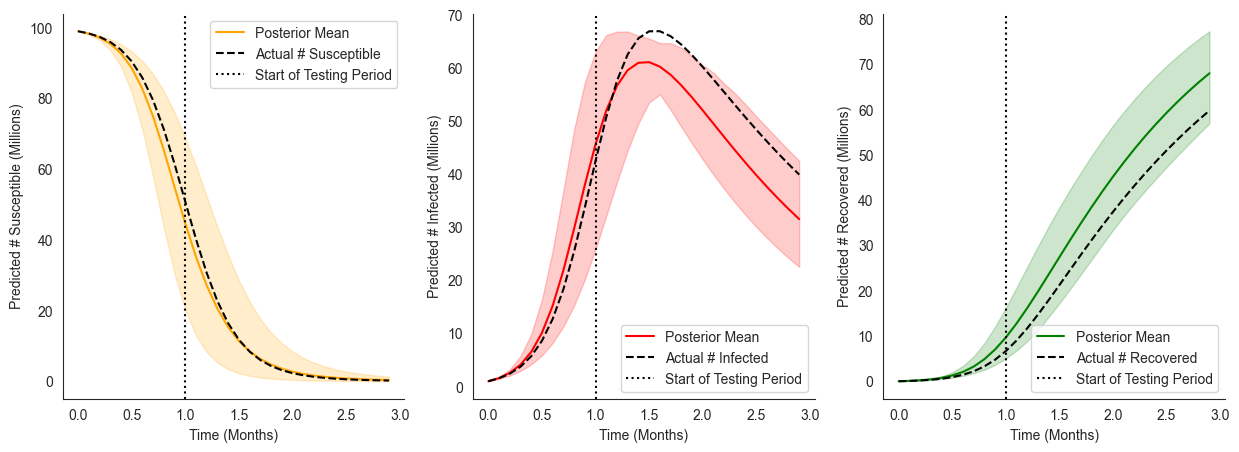

In [88]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    sir_posterior_samples["S"],
    sir_true_traj["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
)
SIR_plot(
    logging_times,
    1,
    sir_posterior_samples["I"],
    sir_true_traj["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
)
SIR_plot(
    logging_times,
    1,
    sir_posterior_samples["R"],
    sir_true_traj["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
)

## Let's explore how different interventions might flatten the infection curve

Suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. Following [2], we define the stength of lockdown measure at time $t$ by $l_t \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

$$
\beta_t = (1 - l_t) \beta_0,
$$

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l_t$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

$$
\begin{split}
    dS_t &= -\beta_t S_t I_t \\
    dI_t &= \beta_t S_t I_t - \gamma I_t \\
    dR_t &= \gamma I_t
\end{split}
$$

where $S_t, I_t, R_t$ denote the number of susceptable, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$.

### We can implement this new model compositionally using our existing SIR model implementation.

In [89]:
class SimpleSIRDynamicsLockdown(SimpleSIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    @pyro.nn.pyro_method
    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0  # time-varing beta parametrized by lockdown strength l_t
        dX["l"] = torch.tensor(0.0)
        # Call the base SIR class diff method
        super().diff(dX, X)


init_state_lockdown = State(
    S=torch.tensor(99.0), 
    I=torch.tensor(1.0), 
    R=torch.tensor(0.0), 
    l=torch.tensor(0.0)
)

### Let's first look at a deterministic intervention where the transmission rate is reduced by 75% between $t=1$ and $t=2$ due to stronger lockdown measures. We see in the figure below that this lockdown measures indeed "flattens" the curve.

In [90]:
def intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, start_time, logging_times) -> State[torch.Tensor]:
    sir = bayesian_sir(SimpleSIRDynamicsLockdown)
    with LogTrajectory(logging_times) as lt:
        with TorchDiffEq():
            with StaticIntervention(time=torch.as_tensor(lockdown_start), intervention=State(l=torch.as_tensor(lockdown_strength))):
                with StaticIntervention(time=torch.as_tensor(lockdown_end), intervention=State(l=torch.tensor(0.0))):
                    simulate(sir, init_state, logging_times[0], logging_times[-1])
                    
    trajectory = lt.trajectory
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, v) for k, v in trajectory.items()]
    return trajectory

In [91]:
lockdown_start = 1.01
lockdown_end = 2.0
lockdown_strength = 0.75

true_intervened_sir = pyro.condition(intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_intervened_trajectory = true_intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, start_time, logging_times)

intervened_sir_predictive = Predictive(intervened_sir, guide=sir_guide, num_samples=num_samples)
intervened_sir_posterior_samples = intervened_sir_predictive(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, start_time, logging_times)

In [ ]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="Start of Lockdown")

## What if we're uncertain about when the lockdown will happen?

In [ ]:
def uncertain_intervened_sir(lockdown_strength, init_state, start_time, logging_times) -> State:
    lockdown_start = pyro.sample("lockdown_start", dist.Uniform(0.5, 1.5))
    lockdown_end = pyro.sample("lockdown_end", dist.Uniform(1.5, 2.5))
    return intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, start_time, logging_times)

In [ ]:
uncertain_intervened_sir_predictive = Predictive(uncertain_intervened_sir, guide=sir_guide, num_samples=num_samples)
uncertain_intervened_sir_posterior_samples = uncertain_intervened_sir_predictive(lockdown_strength, init_state_lockdown, start_time, logging_times)

In [ ]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    uncertain_intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="Start of Lockdown")

## Next, let's consider a state-dependent intervention ("dynamic intervention")

### Here we assume that the government will issue a lockdown measure that reduces the transmission rate by 90% whenever the number of infected people hits 30 million infected. The government removes this lockdown when 20% of the population is recovered.

In [ ]:
def government_lockdown_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return state["I"] - target_state["I"]

    return event_f


def government_lift_policy(target_state: State[torch.tensor]):
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return target_state["R"] - state["R"]

    return event_f


def dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, start_time, logging_times) -> State:
    sir = bayesian_sir(SimpleSIRDynamicsLockdown)
    with LogTrajectory(logging_times) as lt:
        with TorchDiffEq():
            with DynamicIntervention(event_fn=government_lockdown_policy(lockdown_trigger), intervention=State(l=torch.as_tensor(lockdown_strength))):
                with DynamicIntervention(event_fn=government_lift_policy(lockdown_lift_trigger), intervention=State(l=torch.tensor(0.0))):
                    simulate(sir, init_state, logging_times[0], logging_times[-1])
    trajectory = lt.trajectory
    
    # This is a small trick to make the solution variables available to pyro
    [pyro.deterministic(k, v) for k, v in trajectory.items()]
    return trajectory

In [ ]:
lockdown_trigger = State(I=torch.tensor(30.0))
lockdown_lift_trigger = State(R=torch.tensor(20.0))
lockdown_strength = 0.9  # reduces transmission rate by 90%

true_dynamic_intervened_sir = pyro.condition(dynamic_intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_dynamic_intervened_trajectory = true_dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, start_time, logging_times)

dynamic_intervened_sir_predictive = Predictive(dynamic_intervened_sir, guide=sir_guide, num_samples=num_samples)
dynamic_intervened_sir_posterior_samples = dynamic_intervened_sir_predictive(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, start_time, logging_times)

In [ ]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger["I"], color="grey", linestyle="-")
ax[2].axhline(lockdown_lift_trigger["R"], color="grey", linestyle="-")

## Again, we can represent uncertainty about the interventions themselves.

In [ ]:
def uncertain_dynamic_intervened_sir(lockdown_strength, init_state, start_time, logging_times) -> State:
    lockdown_trigger = State(I=pyro.sample("lockdown_trigger", dist.Uniform(30.0, 40.0)))
    lockdown_lift_trigger = State(R=pyro.sample("lockdown_lift_trigger", dist.Uniform(20.0, 30.0)))
    return dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, start_time, logging_times)

In [ ]:
uncertain_dynamic_intervened_sir_predictive = Predictive(uncertain_dynamic_intervened_sir, guide=sir_guide, num_samples=num_samples)
uncertain_dynamic_intervened_sir_posterior_samples = (uncertain_dynamic_intervened_sir_predictive(lockdown_strength, init_state_lockdown, start_time, logging_times))

In [ ]:
# Plot predicted values for S, I, and R with 90% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory["S"],
    "Predicted # Susceptible (Millions)",
    "orange",
    "Actual # Susceptible",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory["I"],
    "Predicted # Infected (Millions)",
    "red",
    "Actual # Infected",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    1,
    uncertain_dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory["R"],
    "Predicted # Recovered (Millions)",
    "green",
    "Actual # Recovered",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger["I"], color="grey", linestyle="-")
ax[2].axhline(lockdown_lift_trigger["R"], color="grey", linestyle="-")

## References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan
2. https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf